# Face Detection using PCA

Using PCA mechanism to correctly assign the face images to persons on the [Yale Face Dataset](https://vismod.media.mit.edu/vismod/classes/mas622-00/datasets/). Download the training data and testing data in this link.

## Assignment 1 (4 scores): Implement PCA using Numpy.

### Import thư viện cần thiết

In [1]:
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
from skimage.transform import resize

### Đọc ảnh train

In [2]:
BASE_DIR = "yalefaces"

person_folders = [
    "person-1", "person-2", "person-3", "person-4", "person-5",
    "person-6", "person-7", "person-8", "person-9", "person-10",
    "person-11", "person-12", "person-13", "person-14", "person-15"
]

- Tạo dict data chứa dữ liệu theo từng folder
- Duyệt tất cả ảnh trong từng thư mục
- Ghép danh sách ảnh của mỗi người thành một ma trận

In [3]:
data = {}

for person_folder in person_folders:
    for filename in os.listdir(os.path.join(BASE_DIR, person_folder)):
        image = imread(os.path.join(BASE_DIR, person_folder, filename))
        image = resize(image, (1, 64, 80), anti_aliasing=True)

        if person_folder not in data:
            data[person_folder] = [image]
        else:
            data[person_folder].append(image)

for person in data:
    data[person] = np.concat(data[person], axis=0).reshape(10, -1)


### Chuẩn hoá ảnh

PCA rất nhạy với scale nên cần chuẩn hóa để đưa dữ liệu về mean = 0 và std = 1, giúp tránh việc độ sáng tối của pixel làm lệch kết quả.

In [4]:
def standardizing(images: np.ndarray) -> np.ndarray:
    images = (images - images.mean()) / images.std()
    images = images.astype(np.float32)
    return images

### Cài đặt PCA 

1. Tạo ma trận hiệp phương sai  
Từ dữ liệu X (150 × 5120), tính XᵀX (5120 × 5120) để mô tả mức độ tương quan giữa các pixel.

2. Tìm eigenvalues & eigenvectors  
Eigenvector cho biết hướng biến thiên, eigenvalue cho biết độ quan trọng; các eigenvector này chính là Eigenfaces.

3. Chọn thành phần quan trọng  
Sắp xếp theo eigenvalue giảm dần và giữ lại 20 eigenvectors lớn nhất

In [ ]:
class PrincipleComponentAnalysis:
    def __init__(self, d_principle: int = 1):
        self.d_principle = d_principle
    
    def fit(self, X: np.ndarray):
        cov = (X.T @ X)
        eigenvalues, eigenvectors = np.linalg.eig(cov)
        max_abs_idx = np.argmax(np.abs(eigenvectors), axis=0)
        signs = np.sign(eigenvectors[max_abs_idx, range(eigenvectors.shape[0])])
        eigenvectors = eigenvectors * signs[np.newaxis, :]
        eigenvectors = eigenvectors.T  

        eigen_pairs = [
            (np.abs(eigenvalues[i]), eigenvectors[i, :])
            for i in range(eigenvectors.shape[0])
        ]

        eigen_pairs.sort(key=lambda pair: pair[0], reverse=True)
        eigenvalues = np.array([value for value, _ in eigen_pairs])
        eigenvectors = np.array([vector for _, vector in eigen_pairs])
        self.principle_values = eigenvalues[:self.d_principle]
        self._W = eigenvectors[:self.d_principle]

    def transform(self, X: np.ndarray) -> np.ndarray:
        X_hat = self._W @ X
        return X_hat

### Trực quan một số ảnh

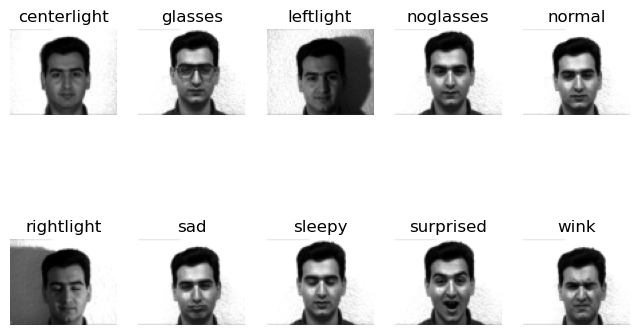

In [13]:
person_folder = random.choice(person_folders)

plt.figure(figsize=(8, 5))
for ith, filename in enumerate(os.listdir(os.path.join(BASE_DIR, person_folder))):
    image = imread(os.path.join(BASE_DIR, person_folder, filename))
    image = image.squeeze(0)
    image = resize(image, (64, 80), anti_aliasing=True)

    plt.subplot(2, 5, ith + 1)
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.title(filename)

### Train

In [14]:
images = []
for person in data:
    images.append(data[person])

images = np.concat(images, axis=0)
images = standardizing(images)

PCA = PrincipleComponentAnalysis(d_principle=20)
PCA.fit(images)

In [15]:
PCA._W.shape

(20, 5120)

## Assignment 2 (4 scores):
- Reading the training images.
- Approximating the Principle Space having **20 dimensions**.
- Visualize the base of this Principle Space.

### Trực quan Eigenfaces

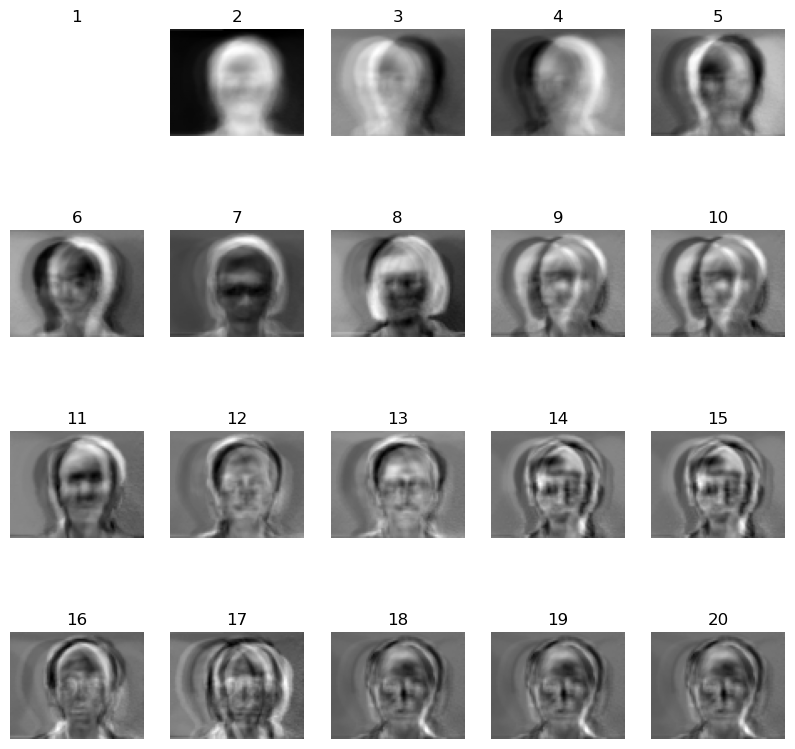

In [17]:
eigenfaces = PCA._W
eigenfaces = eigenfaces.reshape(20, 64, 80)

plt.figure(figsize=(10, 10))
for ith, eigenface in enumerate(eigenfaces):
    plt.subplot(4, 5, ith + 1)
    plt.imshow(eigenface, cmap="gray")
    plt.axis("off")
    plt.title(ith + 1)


### Mean faces

In [22]:
mean_faces = {}
for person in data:
    mean_faces[person] = np.mean(data[person], axis=0)

projected_mean_faces = {}
for person in mean_faces:
    mean_face = mean_faces[person]
    projected_mean_faces[person] = PCA.transform(mean_face)


## Assignment 3 (2 scores): 
- Assign persons to the face images in testing data.
- Evaluate the accuracy of this face recognition system.

### Load dữ liệu test

In [ ]:
labels = []
test_images = []

TEST_DIR = "yalefaces/test"

for filename in os.listdir(os.path.join(TEST_DIR)):
    person_name = filename.split(".")[0]
    labels.append(person_name)

    image = imread(os.path.join(TEST_DIR, filename))
    image = resize(image, (1, 64, 80), anti_aliasing=True)
    test_images.append(image)


In [ ]:
test_images = np.concat(test_images, axis=0)
test_images.shape

(15, 64, 80)

### Tính Euclidean distance

In [ ]:
def Euclide_distance(X: np.ndarray, Y: np.ndarray):
    assert X.shape == Y.shape, f"{X.__str__()} and {Y.__str__()} are miss-shaped"
    return ((X - Y) ** 2).sum() ** 0.5

### Đánh giá Face recognition

In [ ]:
predictions = {}

for label, image in zip(labels, test_images):
    image = image.reshape(-1)
    projected_face = PCA.transform(image)

    closest_distance = np.inf
    closest_person = None

    for person in projected_mean_faces:
        mean_face = projected_mean_faces[person]
        distance = Euclide_distance(mean_face, projected_face)

        if distance < closest_distance:
            closest_distance = distance
            closest_person = person

    predictions[label] = closest_person

EMs = []
for label in predictions:
    EMs.append(label == predictions[label])

print(f"Accuracy: {(np.mean(EMs) * 100):.2f}%")

Accuracy: 66.67%
